# Задача
Коллеги подготовили для вас домашнее задание на классификацию.
В рамках задания вам предлагается решить задачу и сразиться между собой в качестве
Задача по предсказанию согласится ли клиент на депозит (для участия нужна регистрация на kaggle.com)
https://www.kaggle.com/t/8e5b622c6e41422794d3c593c85d59f8
Нужно решить задачу с помощью 3х методов:
- кнн
- дерева принятия решения
- логистической регрессии
и залить на ваш взгляд лучшее решение.
Для зачета нужно:
- предоставить ноутбук с кодом где вы попробовали все 3 метода
- залить предсказания для теста и найти себя в лидерборде (скоро там появится бейзлайн - минимальное решение которое нужно побить по качеству чтоб получить зачет)
Первые 3 места получат дополнительный балл.
Метрика качества ROC-AUC
Дедлайн расширен - 10 дней (14 мая 3 ночи по Москве)

In [1]:
%matplotlib inline
from matplotlib import pyplot, colors
import pandas as pd

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, precision_score, recall_score, accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import RFE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#Создаем датафрейм с описаниями полей для удобства аналитики
from IPython.display import HTML, display
description = pd.DataFrame(data=[
    ["_id", "идентификатор человека", "Данные по клиенту"],
    ["age", "возраст", "Данные по клиенту"],
    ["job", "тип работы (admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown)", "Данные по клиенту"],
    ["marital", "семейное положение (divorced (разведенный и овдовевший),married,single,unknown)", "Данные по клиенту"],
    ["education", "уровень образования (basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown)", "Данные по клиенту"],
    ["default", "есть ли дефолт по кредиту (no,yes,unknown)", "Данные по клиенту"],
    ["housing", "есть ли кредит на жилье (no,yes,unknown)", "Данные по клиенту"],
    ["loan", "есть ли персональный кредит (no,yes,unknown)", "Данные по клиенту"],
    ["contact", "контактный тип связи (cellular,telephone)", "Данные по клиенту"],
    ["month", "последний контактный месяц года (jan, feb, mar, ..., nov, dec)", "Данные по клиенту"],
    ["day_of_week", "последний контактный день недели (mon,tue,wed,thu,fri)", "Данные по клиенту"],
    ["duration", "длительность последнего контакта в секундах. (Важное замечание: этот атрибут сильно влияет на таргет (например, если длительность - 0 сек., то таргет - 0). Тем не менее, продолжительность не известна до выполнения вызова.", "Данные по клиенту"],
    ["campaign", "количество контактов, выполненных для этого клиента в рамках текущей маркетинговой кампании (включая последний контакт)", "Данные по клиенту"],
    ["pdays", "количество дней прошедших последнего контакта с клиентом с предыдущей маркетинговой кампании (999 означает, что ранее с клиентом не контактировали)", "Данные по клиенту"],
    ["previous", "количество контактов, выполненных до текущей маркетинговой кампании для этого клиента", "Данные по клиенту"],
    ["poutcome", "результат предыдущей маркетинговой кампании (failure,nonexistent,success)", "Данные по клиенту"],
    ["emp.var.rate", "изменение уровня занятости (квартальный показатель)", "Внешние данные"],
    ["cons.price.idx", "индекс потребительских цен (ежемесячный показатель)", "Внешние данные"],
    ["cons.conf.idx", "индекс доверия потребителя (ежемесячный показатель)", "Внешние данные"],
    ["euribor3m", "курс Euribor (ежедневный показатель)", "Внешние данные"],
    ["nr.employed", "количество сотрудников (квартальный показатель)", "Внешние данные"]
],columns=['field','description','context']).set_index('field')
description

,description,context
field,,
_id,идентификатор человека,Данные по клиенту
age,возраст,Данные по клиенту
job,"тип работы (admin.,blue-collar,entrepreneur,ho...",Данные по клиенту
marital,семейное положение (divorced (разведенный и ов...,Данные по клиенту
education,"уровень образования (basic.4y,basic.6y,basic.9...",Данные по клиенту
default,"есть ли дефолт по кредиту (no,yes,unknown)",Данные по клиенту
housing,"есть ли кредит на жилье (no,yes,unknown)",Данные по клиенту
loan,"есть ли персональный кредит (no,yes,unknown)",Данные по клиенту
contact,"контактный тип связи (cellular,telephone)",Данные по клиенту


In [4]:
train = pd.read_csv('train.csv', index_col="_id")
X_test  = pd.read_csv('test.csv', index_col="_id")

## Анализ данных

In [5]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target
_id,,,,,,,,,,,,,,,,,,,,,
df7489733b004bbe40d3d37b34f82419,54,technician,married,professional.course,unknown,no,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
905a0b9a5456ee962223033473666be3,36,services,single,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
02d69c07ec6d68e31d641edd45ce61cd,53,blue-collar,married,basic.4y,no,yes,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0
e492fbe0cccaf67cdb5c0944dbc8a167,34,blue-collar,married,basic.9y,no,yes,yes,telephone,may,wed,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
ac2dc6f5835bdea8e71dd99b65208d07,29,services,single,university.degree,no,yes,no,telephone,aug,fri,...,1,999,0,nonexistent,-1.7,94.027,-38.3,0.890,4991.6,0


In [6]:
train.shape

(24712, 21)

In [7]:
X_test.shape

(16476, 20)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24712 entries, df7489733b004bbe40d3d37b34f82419 to 46d0d25dfd1def79632dd437261d0b5c
Data columns (total 21 columns):
age               24712 non-null int64
job               24712 non-null object
marital           24712 non-null object
education         24712 non-null object
default           24712 non-null object
housing           24712 non-null object
loan              24712 non-null object
contact           24712 non-null object
month             24712 non-null object
day_of_week       24712 non-null object
duration          24712 non-null int64
campaign          24712 non-null int64
pdays             24712 non-null int64
previous          24712 non-null int64
poutcome          24712 non-null object
emp.var.rate      24712 non-null float64
cons.price.idx    24712 non-null float64
cons.conf.idx     24712 non-null float64
euribor3m         24712 non-null float64
nr.employed       24712 non-null float64
target            24712 non-null int64

In [9]:
train_test = pd.concat([train, X_test], axis=0, keys=['train','test'], names=['csv','_id']).reset_index(level='csv')

In [61]:
#сначала проанилизруем признаки преимущественно с числовыми диапазонами
for cname in train.columns:
    if (train.dtypes[cname] != object) & (cname in description.index):    
        print("{}: уникальных {}; описание: {}\n".format(
            cname,
            len(train[cname].unique()),
            description.loc[cname, 'description']
        ))

age: уникальных 77; описание: возраст

duration: уникальных 1384; описание: длительность последнего контакта в секундах. (Важное замечание: этот атрибут сильно влияет на таргет (например, если длительность - 0 сек., то таргет - 0). Тем не менее, продолжительность не известна до выполнения вызова.

campaign: уникальных 40; описание: количество контактов, выполненных для этого клиента в рамках текущей маркетинговой кампании (включая последний контакт)

pdays: уникальных 26; описание: количество дней прошедших последнего контакта с клиентом с предыдущей маркетинговой кампании (999 означает, что ранее с клиентом не контактировали)

previous: уникальных 7; описание: количество контактов, выполненных до текущей маркетинговой кампании для этого клиента

emp.var.rate: уникальных 10; описание: изменение уровня занятости (квартальный показатель)

cons.price.idx: уникальных 26; описание: индекс потребительских цен (ежемесячный показатель)

cons.conf.idx: уникальных 26; описание: индекс доверия по

In [62]:
#дефолтный pairplot неустроил, либо руки у меня кривые :)
def show_scatter(df, x, y, hue, agg_func, ax, norm = None):
    df=df.groupby([x, y]).agg({hue:agg_func, x:'count'}).rename(columns={x:'count'}).reset_index()
    df.plot.scatter(x=x,y=y,c=hue,s=(df['count']/df['count'].max()*200+10), ax=ax, cmap=pyplot.cm.winter_r, norm=norm)

def show_hist(df, feauter, hue, ax):
    df = df.copy()
    df['row_counter'] = 1
    df.pivot_table('row_counter', index=[feauter], columns=[hue], aggfunc='count').plot(kind='bar', stacked=True, cmap=pyplot.cm.winter_r, ax=ax)

def pairplot_scatter(df, x_vars, y_vars, hue, agg_func):
           
    df = df.copy()
    
    x_vars = [x for x in x_vars if (x in df.columns)]
    y_vars = [x for x in y_vars if (x in df.columns)]
    x_vars.remove(hue)
    y_vars.remove(hue)
    
    for cname in (y_vars + x_vars):
        if len(df[cname].unique())>20:
            step = (df[cname].max() - df[cname].min())/10
            df[cname] = df[cname] // step * step
    
    fig, axes = pyplot.subplots(nrows=len(y_vars), ncols=len(x_vars), squeeze=False, figsize=(min(40,len(x_vars)*7), len(y_vars)*5))
    
    for idx, x in enumerate(x_vars):
        for idy, y in enumerate(y_vars):
            if ~(x in [y]):
                show_scatter(df, x, y, hue, agg_func, axes[idy, idx])
            else:
                show_hist(df, x, hue, axes[idy, idx])


In [63]:
def pairplot_scatter_pairs(df, pair_vars, hue, agg_func, norm):
           
    df = df.copy()
    
    pair_vars = [x for x in pair_vars if not (hue in x)]    
    
    for cnames in pair_vars:
        for cname in cnames:
            if len(df[cname].unique())>20:
                step = (df[cname].max() - df[cname].min())/10
                df[cname] = df[cname] // step * step
    
    cols = 4
    rows = len(pair_vars) // cols
    fig, axes = pyplot.subplots(nrows=rows, ncols=cols, squeeze=False, figsize=(35, rows*5))

    for id, (x, y) in enumerate(pair_vars):
            if not (x in [y, hue]):
                show_scatter(df, x, y, hue, agg_func, axes[id // cols, id % cols], norm)
            else:
                show_hist(df, x, hue, axes[id // cols, id % cols])

In [64]:
def pairplot_feauter(feauter):
    pairplot_scatter_pairs(
    map_categories(train, category_mapper, []), 
    [[feauter]+[x] for x in train.columns if ~(x in [feauter])], 
    'target', 
    'mean', 
    colors.Normalize(vmin=0, vmax=1)
)

## Фича: [age]

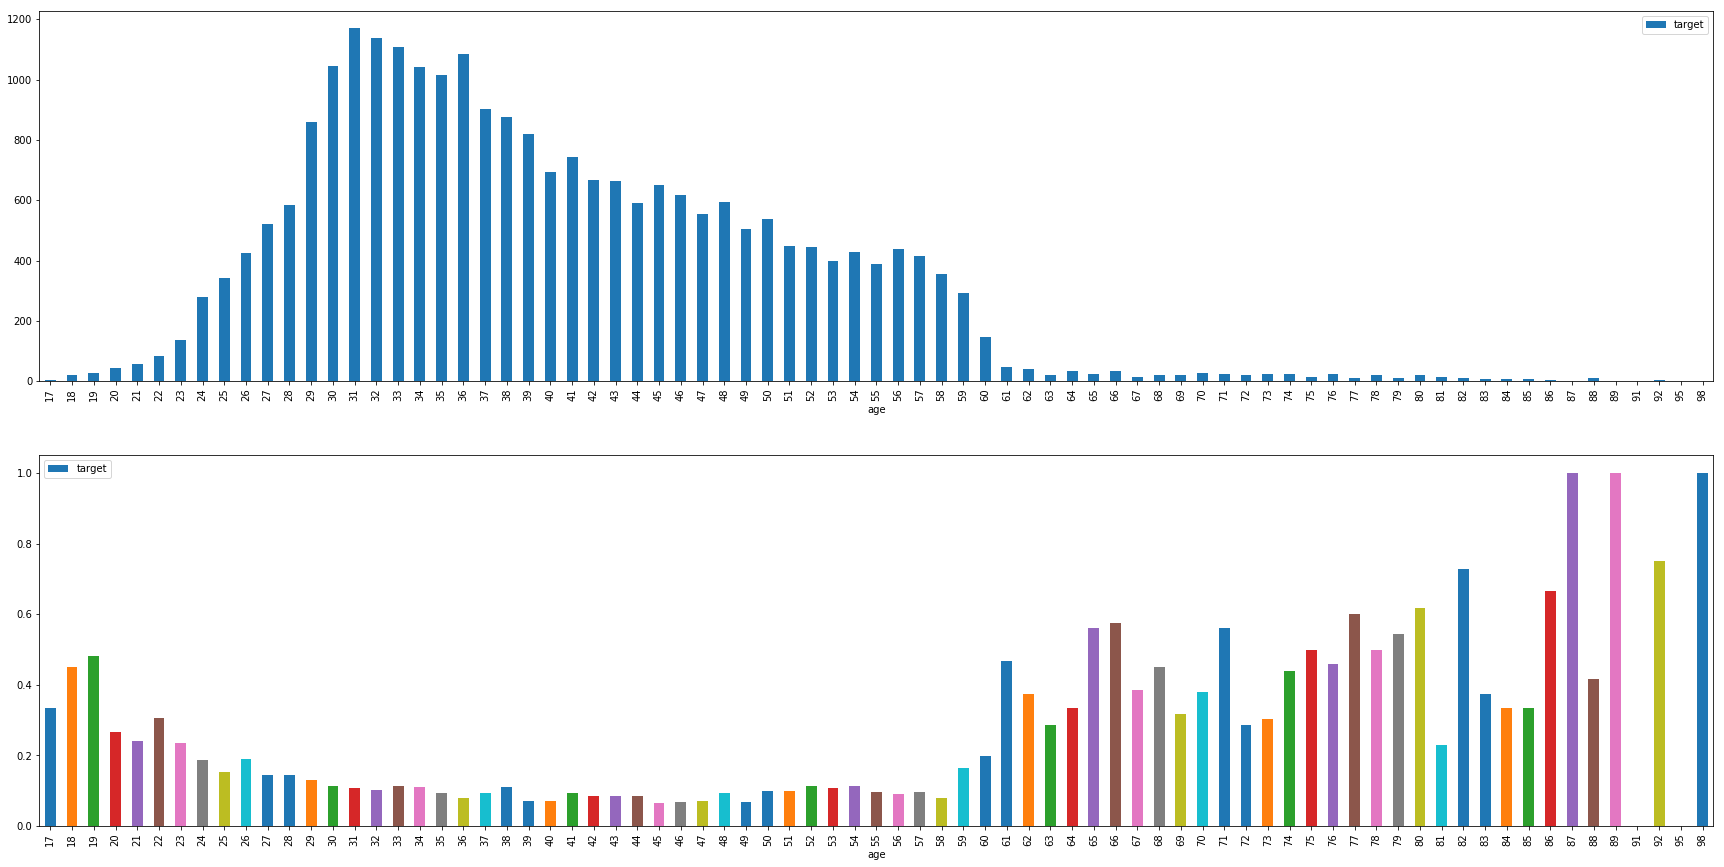

In [65]:
fig, axes = pyplot.subplots(2,1, squeeze=False, figsize=(30,15))
train.groupby(['age']).agg({'target':'count'}).plot(kind='bar', ax = axes[0,0])
train.groupby(['age']).agg({'target':'mean'}).reset_index().plot(x='age', y='target', kind='bar', ax = axes[1,0])

##### [Age] 
Выделяем трудоспособное население от 25 до 58 лет включительно.
~~Дополняем логикой __*map_category*__~~
Лучше выделим целевую аудиторию рекламных компаний, см. ниже

## Фича [duration]

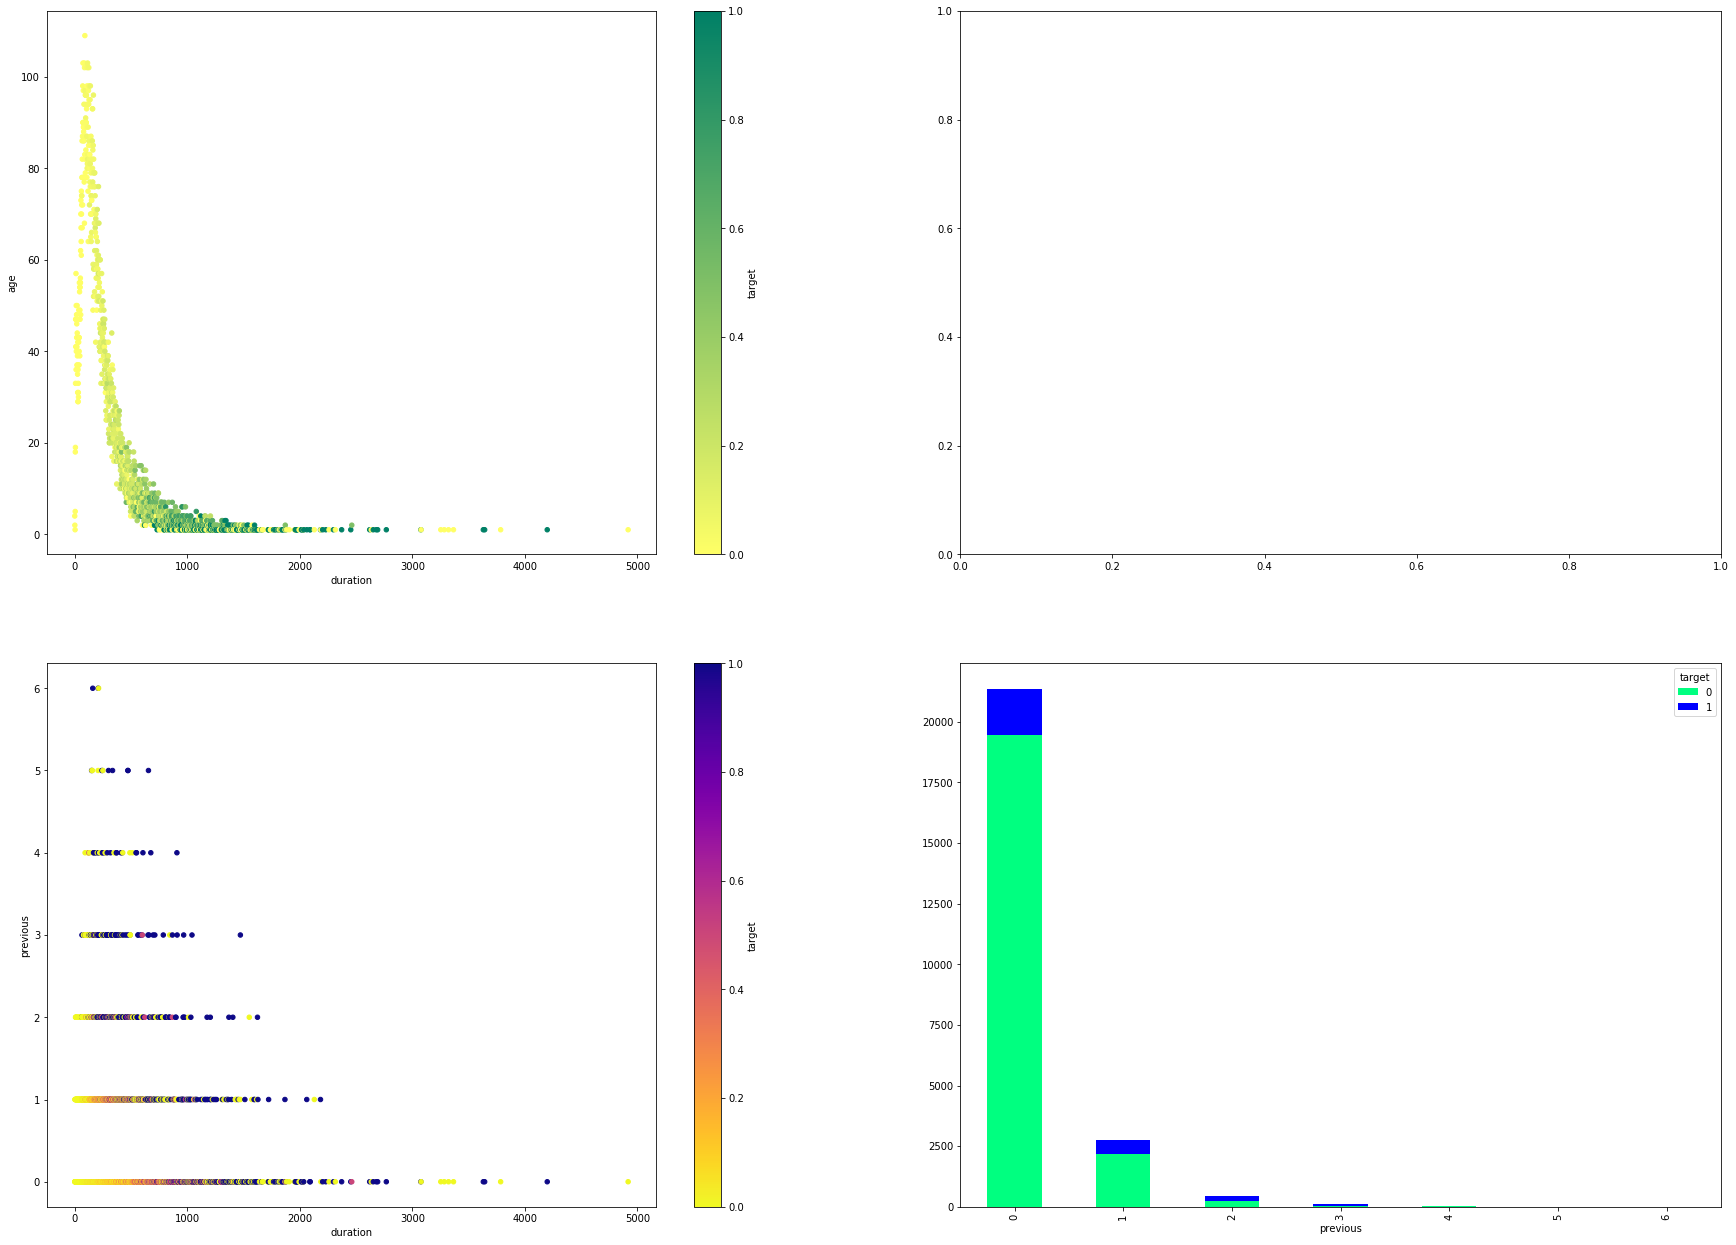

In [66]:
fig, axes = pyplot.subplots(2,2, squeeze=False, figsize=(30,22))
train.groupby(['duration']).agg({'age':'count', 'target':'mean'}).reset_index().plot.scatter(x='duration', y='age', c='target', cmap=pyplot.cm.summer_r, ax = axes[0,0])
train.groupby(['duration','previous']).agg({'target':'mean'}).reset_index().plot.scatter(x='duration', y='previous', c='target', cmap=pyplot.cm.plasma_r, ax = axes[1,0])
show_hist(train, 'previous', 'target', axes[1,1])

##### [duration] & [previous]
Два признака посчитаем логистическую регрессию

In [67]:
def calculate_lr_vars(df):
    
    y = list(df['target'])
    X = df.drop(columns='target')
    
    lr = LogisticRegression(random_state=42, )
    lr.fit(X,y)
    intercept, coef = lr.intercept_[0], lr.coef_[0]
    
    df=df.copy()
    df['new'] = intercept + X.iloc[:,0]*coef[0] + X.iloc[:,1]*coef[1]
    print('df[\'new_feature\'] = {} + df[\'{}\']*{} + df[\'{}\']*{}'.format(
        intercept,
        X.columns[0],
        coef[0],
        X.columns[1],
        coef[1]
    ))
    
    fig, axes = pyplot.subplots(1,1,figsize=(10,7), squeeze=False)
    show_scatter(df, x='new', y=X.columns[0], hue='target', agg_func='mean', ax=axes[0,0])

df['new_feature'] = -3.6064671271553124 + df['duration']*0.0037342820277683555 + df['previous']*1.0693138449645634


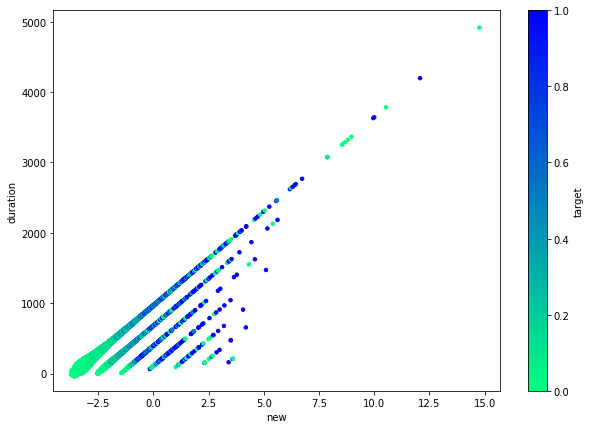

In [18]:
calculate_lr_vars(train[['duration', 'previous', 'target']])

## Фича [month]

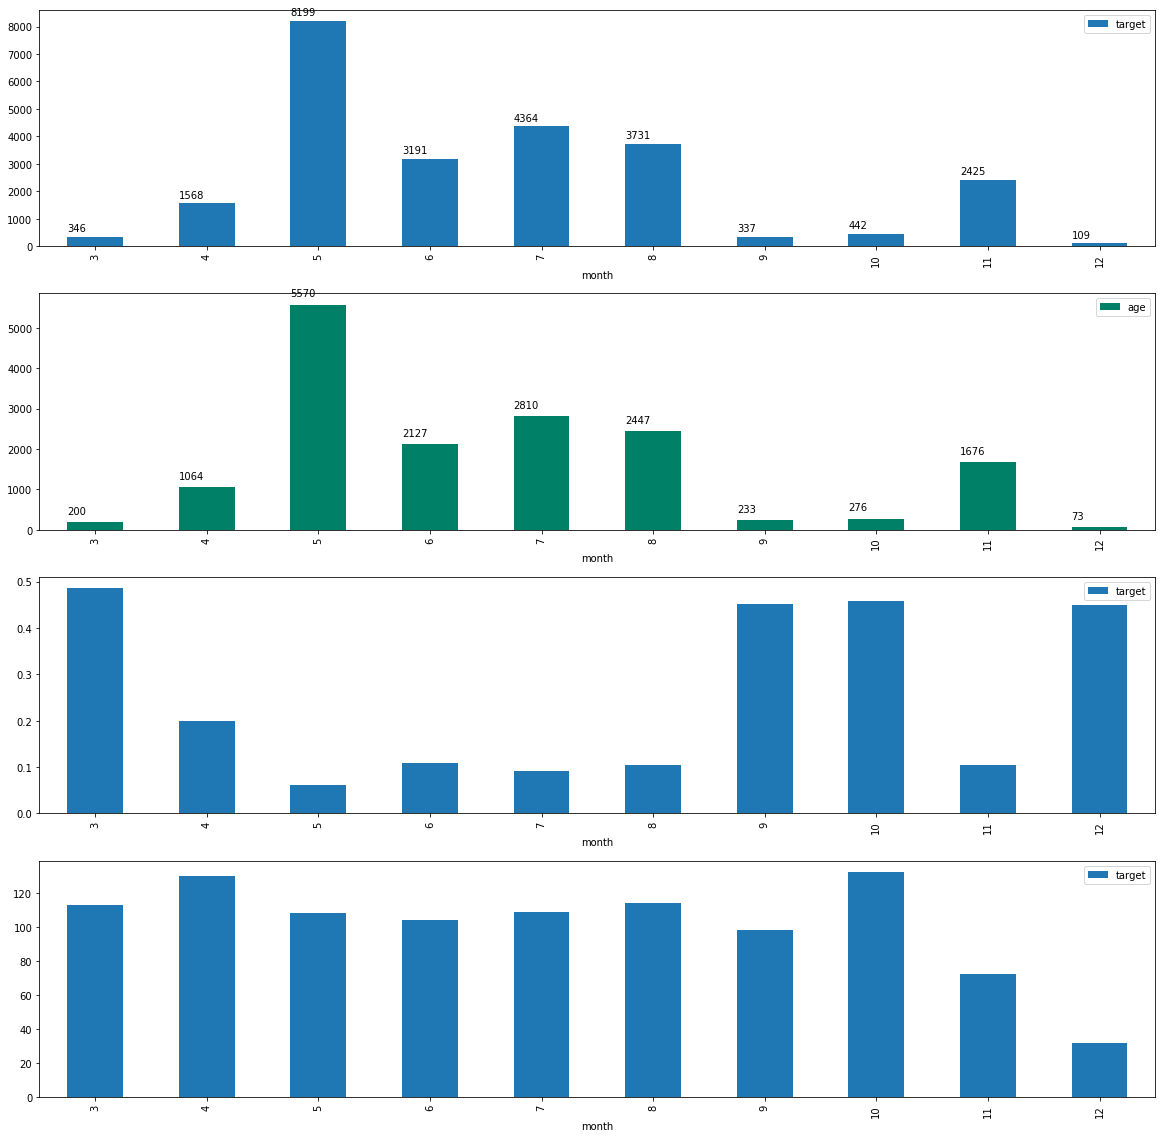

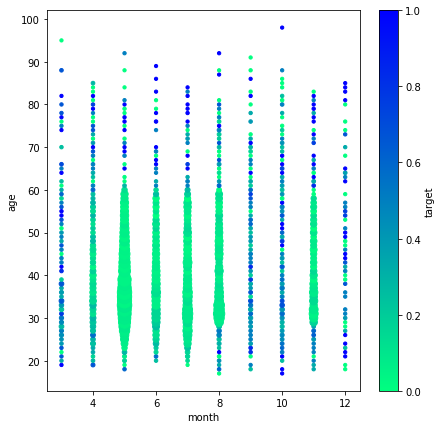

In [19]:
def test_months(df):
    df = df.copy().reset_index()
    
    months = {
        'apr' : 4,
        'aug' : 8,
        'dec' : 12,
        'jul' : 7,
        'jun' : 6,
        'mar' : 3,
        'may' : 5,
        'nov' : 11,
        'oct' : 10,
        'sep' : 9        
    }
    
    df.month = df.month.map(lambda x: months[x])
    
    fig, axes = pyplot.subplots(4,1, squeeze=False, figsize=(20,20))
    
    dfg = df[df['csv']=='train'].groupby(['month']).agg({'target':'count'}).reset_index()
    
    dfg.plot(x='month', kind='bar', ax = axes[0,0])
    dfg.apply(lambda x: axes[0,0].annotate(x['target'], (x['month']-3.25, x['target']+200)), axis=1)
    
    dfgm = df.groupby(['month']).agg({'target':'mean'}).reset_index()
    dfgm.plot(x='month', kind='bar', ax = axes[2,0])
    
    dfgm['target'] = dfg['target']*(dfgm['target']**1.55) #достаточно хорошо выравнивает график
    dfgm.plot(x='month', kind='bar', ax = axes[3,0])
    
    dfg = df[df['csv']=='test'].groupby(['month']).agg({'age':'count'}).reset_index()
    
    dfg.plot(x='month', kind='bar', ax = axes[1,0], cmap=pyplot.cm.summer)
    dfg.apply(lambda x: axes[1,0].annotate(x['age'], (x['month']-3.25, x['age']+200)), axis=1)
    
    fig, axes = pyplot.subplots(1,1, squeeze=False, figsize=(7,7))
    show_scatter(df = df[df['csv']=='train'], x ='month', y ='age', hue='target', ax = axes[0,0], agg_func='mean')
    

test_months(train_test)
    

##### [month]
Видно, что в марте, сентябре, октябре и декабре не было сильной рекламной активности, вероятно высокий уровень отклика связан с проявлением инициативы самим клиентами, отсюда вывод, что верятность достижения цели зависит от реклмной активности в этот период. Видим также что в тесте активны те же самые месяца в таких же пропорциях. Отрейтингуем периоды активности рекламной компании.
- __март__, __сентябрь__, __октябрь__, __декабрь__ = 0, нет рекламной активности
- __апрель__ - старт рекламной активности = 1
- __июнь__, __июль__, __август__ - рекламная активность была нормализована, однако наблюдается какой-то всплеск в __ноябре__, его эффект схож с летними месяцами = 2
- __май__ - пик рекламной активности, верятно было много спама = 3

Также видно. что основная рекламная активность приходится на работоспособное население с небольшим шифтом в августе и октябре (поднимается нижний порог возраста), пометим людей, которые попадабт в целевую аудиторию рекламной активности.
соответственно нас интересуют люди:
- в __мае__, __июне__, __июле__ - в возрасте __с 24 до 60 лет__
- в __апреле__, __августе__ и __октябре__ - в возрасте __с 29 до 60 лет__

## Фича [campaign]

количество контактов, выполненных для этого клиента в рамках текущей маркетинговой кампании (включая последний контакт)


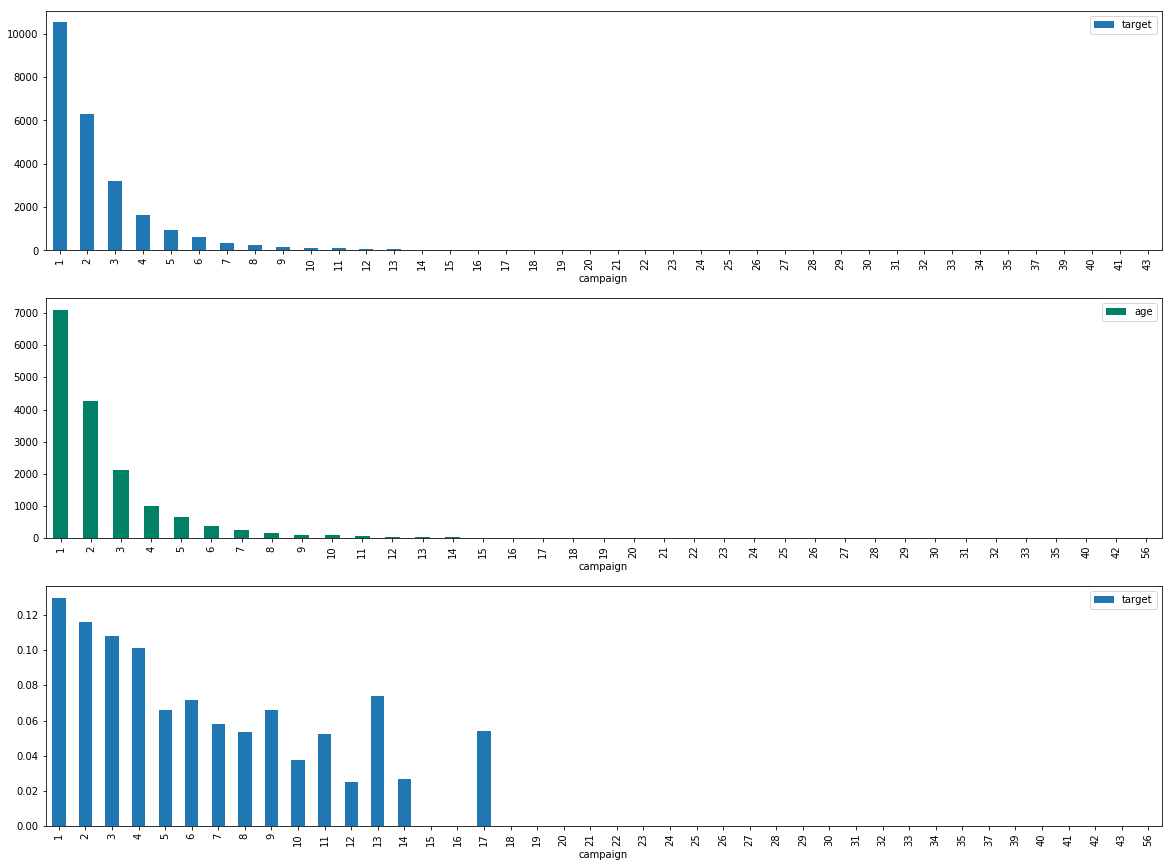

In [20]:
def test_campaign(df):
    df = df.copy().reset_index()
    
    months = {
        'apr' : 4,
        'aug' : 8,
        'dec' : 12,
        'jul' : 7,
        'jun' : 6,
        'mar' : 3,
        'may' : 5,
        'nov' : 11,
        'oct' : 10,
        'sep' : 9        
    }
    day_of_week = {
        'fri' : 5,
        'mon' : 1,
        'thu' : 4,
        'tue' : 2,
        'wed' : 3
    }
    
    df.month = df.month.map(lambda x: months[x])
    df.day_of_week = df.day_of_week.map(lambda x: day_of_week[x])
    
    fig, axes = pyplot.subplots(3,1, squeeze=False, figsize=(20,15))
    
    dfg = df[df['csv']=='train'].groupby(['campaign']).agg({'target':'count'}).reset_index()
    
    dfg.plot(x='campaign', kind='bar', ax = axes[0,0])
    #dfg.apply(lambda x: axes[0,0].annotate(x['target'], (x['month']-3.25, x['target']+200)), axis=1)
    
    dfgm = df.groupby(['campaign']).agg({'target':'mean'}).reset_index()
    dfgm.plot(x='campaign', kind='bar', ax = axes[2,0])
    
#    dfgm['target'] = dfg['target']*(dfgm['target']**1.55) #достаточно хорошо выравнивает график
#    dfgm.plot(x='campaign', kind='bar', ax = axes[3,0])
    
    dfg = df[df['csv']=='test'].groupby(['campaign']).agg({'age':'count'}).reset_index()
    
    dfg.plot(x='campaign', kind='bar', ax = axes[1,0], cmap=pyplot.cm.summer)
    #dfg.apply(lambda x: axes[1,0].annotate(x['age'], (x['campaign']-3.25, x['age']+200)), axis=1)
    
#    fig, axes = pyplot.subplots(2,2, squeeze=False, figsize=(20,14))
#    show_scatter(df = df[df['csv']=='train'], x ='campaign', y ='age', hue='target', ax = axes[0,0], agg_func='mean')
#    show_scatter(df = df[ (df['csv']=='train') & (df['pdays']<999)], x ='campaign', y ='pdays', hue='target', ax = axes[1,0], agg_func='mean')
#    show_scatter(df = df[df['csv']=='train'], x ='campaign', y ='month', hue='target', ax = axes[0,1], agg_func='mean')
#    show_scatter(df = df[df['csv']=='train'], x ='campaign', y ='day_of_week', hue='target', ax = axes[1,1], agg_func='mean')

print(description.loc['campaign','description'])
test_campaign(train_test)

##### [campaign]
Чем меньше контактов, тем больше вероятность достижения цели.
делаем градацию:
- 1
- 2
- 3
- 4
- 5...9
- 10...17
- \>= 18

напишем функцию __prepare_campaign__

In [21]:
def prepare_campaign(campaign):
    if campaign >= 18:
        return 7
    if campaign >= 10:
        return 6
    if campaign >= 5:
        return 5
    return campaign

## Фича [pdays]

количество дней прошедших последнего контакта с клиентом с предыдущей маркетинговой кампании (999 означает, что ранее с клиентом не контактировали)


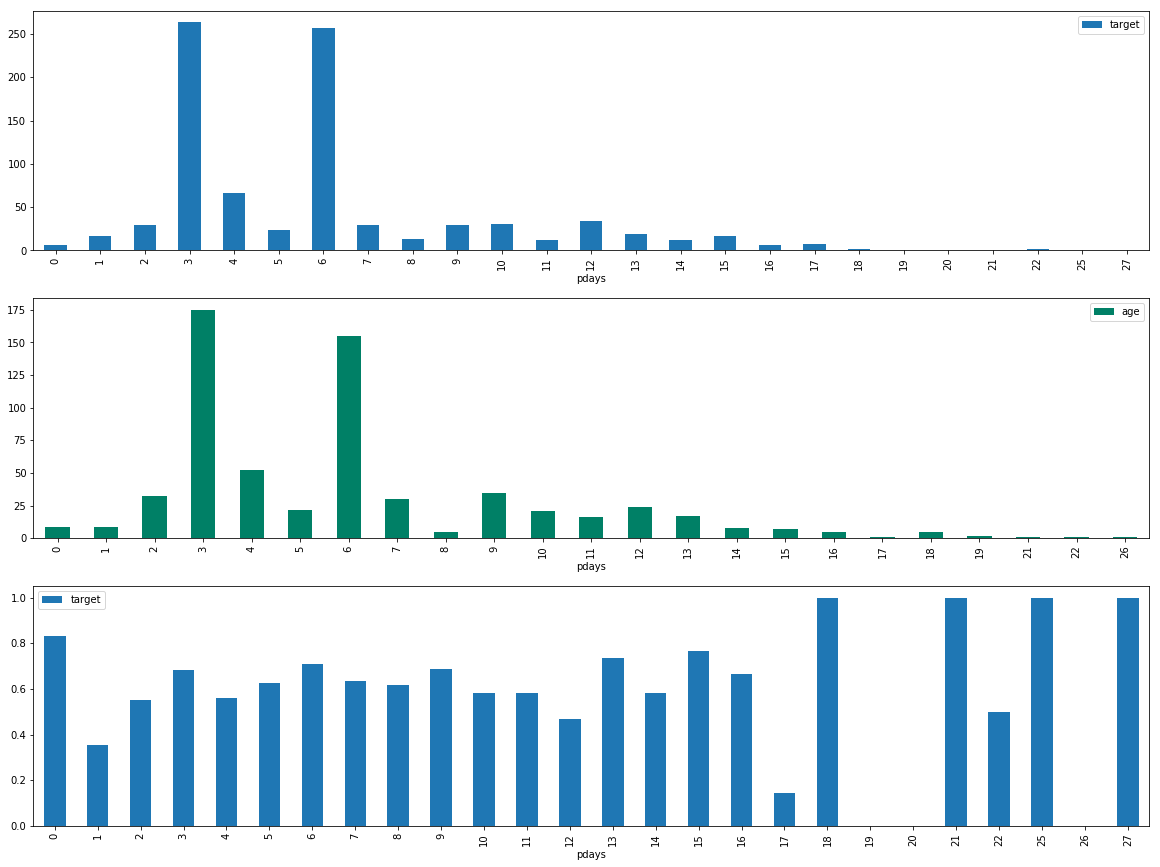

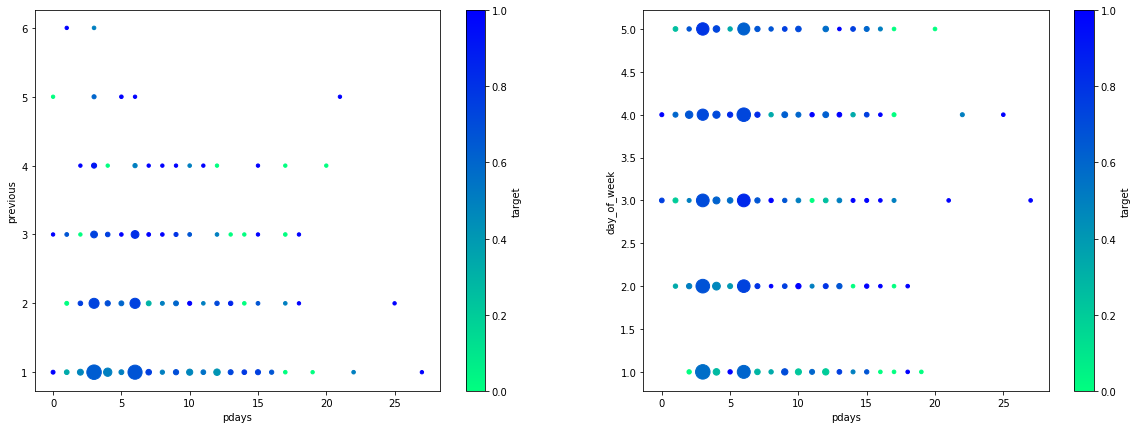

In [22]:
def test_pdyas(df):
    df = df.copy().reset_index()
    
    months = {
        'apr' : 4,
        'aug' : 8,
        'dec' : 12,
        'jul' : 7,
        'jun' : 6,
        'mar' : 3,
        'may' : 5,
        'nov' : 11,
        'oct' : 10,
        'sep' : 9        
    }
    day_of_week = {
        'fri' : 5,
        'mon' : 1,
        'thu' : 4,
        'tue' : 2,
        'wed' : 3
    }
    
    df.month = df.month.map(lambda x: months[x])
    df.day_of_week = df.day_of_week.map(lambda x: day_of_week[x])
    
    fig, axes = pyplot.subplots(3,1, squeeze=False, figsize=(20,15))
    
    dfg = df[(df['csv']=='train') & (df['pdays']<999)].groupby(['pdays']).agg({'target':'count'}).reset_index()
    
    dfg.plot(x='pdays', kind='bar', ax = axes[0,0])
    #dfg.apply(lambda x: axes[0,0].annotate(x['target'], (x['month']-3.25, x['target']+200)), axis=1)
    
    dfgm = df[df['pdays']<999].groupby(['pdays']).agg({'target':'mean'}).reset_index()
    dfgm.plot(x='pdays', kind='bar', ax = axes[2,0])
    
#    dfgm['target'] = dfg['target']*(dfgm['target']**1.55) #достаточно хорошо выравнивает график
#    dfgm.plot(x='campaign', kind='bar', ax = axes[3,0])
    
    dfg = df[(df['csv']=='test') & (df['pdays']<999)].groupby(['pdays']).agg({'age':'count'}).reset_index()
    
    dfg.plot(x='pdays', kind='bar', ax = axes[1,0], cmap=pyplot.cm.summer)
    #dfg.apply(lambda x: axes[1,0].annotate(x['age'], (x['campaign']-3.25, x['age']+200)), axis=1)
    
    fig, axes = pyplot.subplots(1,2, squeeze=False, figsize=(20,7))
    show_scatter(df = df[(df['csv']=='train') & (df['pdays']<999)], x ='pdays', y ='previous', hue='target', ax = axes[0,0], agg_func='mean')
    show_scatter(df = df[(df['csv']=='train') & (df['pdays']<999)], x ='pdays', y ='day_of_week', hue='target', ax = axes[0,1], agg_func='mean')

print(description.loc['pdays','description'])
test_pdyas(train_test)

##### [pdays]
количествой дней, прошедших с последнего контакта не так важно, как сам факта коммуникации. поэтому превращаем в бинарный признак 
- 1 if pdays<999 else 0

## Занятость населения, персонал и т.д.

изменение уровня занятости (квартальный показатель)


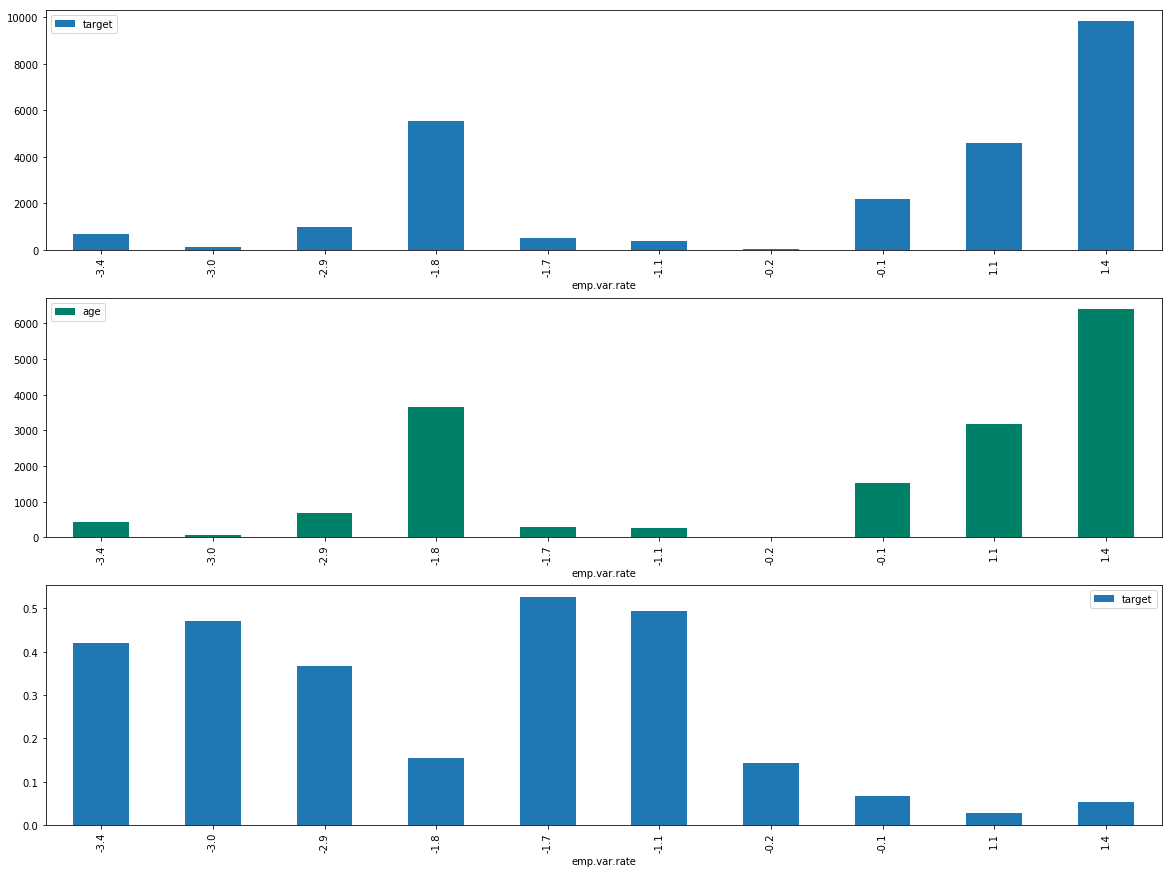

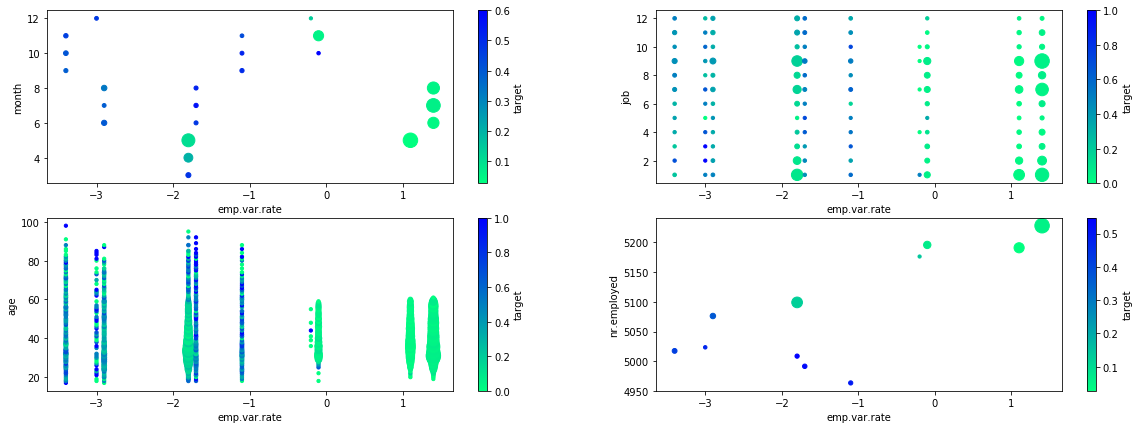

In [23]:
f = 'emp.var.rate'
def test_emp(df):
    df = df.copy().reset_index()
    
    months = {
        'apr' : 4,
        'aug' : 8,
        'dec' : 12,
        'jul' : 7,
        'jun' : 6,
        'mar' : 3,
        'may' : 5,
        'nov' : 11,
        'oct' : 10,
        'sep' : 9        
    }
    day_of_week = {
        'fri' : 5,
        'mon' : 1,
        'thu' : 4,
        'tue' : 2,
        'wed' : 3
    }
    job ={
        'blue-collar': 1,
        'services': 2,
        'entrepreneur': 3,
        'housemaid': 4,
        'unknown': 5,
        'self-employed': 6,
        'technician': 7,
        'management': 8,
        'admin.': 9,
        'unemployed': 10,
        'retired': 11,
        'student': 12
    }
    
    df.month = df.month.map(lambda x: months[x])
    df.day_of_week = df.day_of_week.map(lambda x: day_of_week[x])
    df.job = df.job.map(lambda x: job[x])
    
    fig, axes = pyplot.subplots(3,1, squeeze=False, figsize=(20,15))
    
    dfg = df[(df['csv']=='train')].groupby([f]).agg({'target':'count'}).reset_index()
    
    dfg.plot(x=f, kind='bar', ax = axes[0,0])
    #dfg.apply(lambda x: axes[0,0].annotate(x['target'], (x['month']-3.25, x['target']+200)), axis=1)
    
    dfgm = df.groupby([f]).agg({'target':'mean'}).reset_index()
    dfgm.plot(x=f, kind='bar', ax = axes[2,0])
    
#    dfgm['target'] = dfg['target']*(dfgm['target']**1.55) #достаточно хорошо выравнивает график
#    dfgm.plot(x='campaign', kind='bar', ax = axes[3,0])
    
    dfg = df[(df['csv']=='test') ].groupby([f]).agg({'age':'count'}).reset_index()
    
    dfg.plot(x=f, kind='bar', ax = axes[1,0], cmap=pyplot.cm.summer)
    #dfg.apply(lambda x: axes[1,0].annotate(x['age'], (x['campaign']-3.25, x['age']+200)), axis=1)
    
    fig, axes = pyplot.subplots(2,2, squeeze=False, figsize=(20,7))    
    show_scatter(df = df[(df['csv']=='train')], x =f, y ='month', hue='target', ax = axes[0,0], agg_func='mean')    
    show_scatter(df = df[(df['csv']=='train')], x =f, y ='job', hue='target', ax = axes[0,1], agg_func='mean')
    show_scatter(df = df[(df['csv']=='train')], x =f, y ='age', hue='target', ax = axes[1,0], agg_func='mean')
    show_scatter(df = df[(df['csv']=='train')], x =f, y ='nr.employed', hue='target', ax = axes[1,1], agg_func='mean')
    
    return (
        pd.pivot_table(df, values='target', index='month', columns=f, aggfunc='count').sort_index(axis=0, ascending=False), 
        pd.pivot_table(df, values='target', index='month', columns=f, aggfunc='mean').sort_index(axis=0, ascending=False),
        pd.pivot_table(df, values='target', index='nr.employed', columns=f, aggfunc='count').sort_index(axis=0, ascending=False), 
        pd.pivot_table(df, values='target', index='nr.employed', columns=f, aggfunc='mean').sort_index(axis=0, ascending=False),
        df.groupby([f, 'nr.employed', 'month']).agg({'target':'mean', 'age':'count'}).reset_index().rename(columns={'target':'emp_map', 'age':'count'})
    )

print(description.loc[f,'description'])
dfs = test_emp(train_test)

In [24]:
dfs[1]

emp.var.rate,-3.4,-3.0,-2.9,-1.8,-1.7,-1.1,-0.2,-0.1,1.1,1.4
month,,,,,,,,,,
12,NaN,0.470588,NaN,NaN,NaN,NaN,0.142857,NaN,NaN,NaN
11,0.458333,NaN,NaN,NaN,NaN,0.433735,NaN,0.055033,NaN,NaN
10,0.410072,NaN,NaN,NaN,NaN,0.521008,NaN,0.600000,NaN,NaN
9,0.389937,NaN,NaN,NaN,NaN,0.505618,NaN,NaN,NaN,NaN
8,NaN,NaN,0.333333,NaN,0.524138,NaN,NaN,NaN,NaN,0.052446
7,NaN,NaN,0.392523,NaN,0.564103,NaN,NaN,NaN,NaN,0.061792
6,NaN,NaN,0.400491,NaN,0.478873,NaN,NaN,NaN,NaN,0.045042
5,NaN,NaN,NaN,0.104230,NaN,NaN,NaN,NaN,0.027499,NaN
4,NaN,NaN,NaN,0.200255,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
dfs[3]

emp.var.rate,-3.4,-3.0,-2.9,-1.8,-1.7,-1.1,-0.2,-0.1,1.1,1.4
nr.employed,,,,,,,,,,
5228.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054318
5195.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.066329,NaN,NaN
5191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027499,NaN
5176.3,NaN,NaN,NaN,NaN,NaN,NaN,0.142857,NaN,NaN,NaN
5099.1,NaN,NaN,NaN,0.125341,NaN,NaN,NaN,NaN,NaN,NaN
5076.2,NaN,NaN,0.367934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5023.5,NaN,0.470588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5017.5,0.421133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5008.7,NaN,NaN,NaN,0.547074,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
dfs[4]

,emp.var.rate,nr.employed,month,emp_map,count
0,-3.4,5017.5,9,0.389937,267
1,-3.4,5017.5,10,0.410072,447
2,-3.4,5017.5,11,0.458333,357
3,-3.0,5023.5,12,0.470588,172
4,-2.9,5076.2,6,0.400491,715
5,-2.9,5076.2,7,0.392523,178
6,-2.9,5076.2,8,0.333333,770
7,-1.8,5008.7,3,0.557576,264
8,-1.8,5008.7,4,0.530000,174
9,-1.8,5008.7,5,0.546875,212


In [27]:
emp_map = dfs[4].drop(columns='count')

##### [emp.var.rate]
индекс занятости имеет странное поведение, в некоторых месяцах он принимает разные значения, которые не зависят от должности... но индекс отлично коррелирует с фичей __nr.employed__ а в паре они также коррелируют еще и с месяцем

Объединим фичи __emp.var.rate__, __month__ и __nr.employed__ и выведем их в другую фичу, которая в качестве значения будет принимать __mean__ от __target__ запомним датафрейм __emp_map__ для дальнейшего джойна и сразу же проверим как новая фича коррелируется по месяцам

##### идем дальше...
- __cons.price.idx__: уникальных 26; описание: индекс потребительских цен (ежемесячный показатель)
- __cons.conf.idx__: уникальных 26; описание: индекс доверия потребителя (ежемесячный показатель)
- __euribor3m__: уникальных 306; описание: курс Euribor (ежедневный показатель)

## Внешние факторы: финансовые показатели

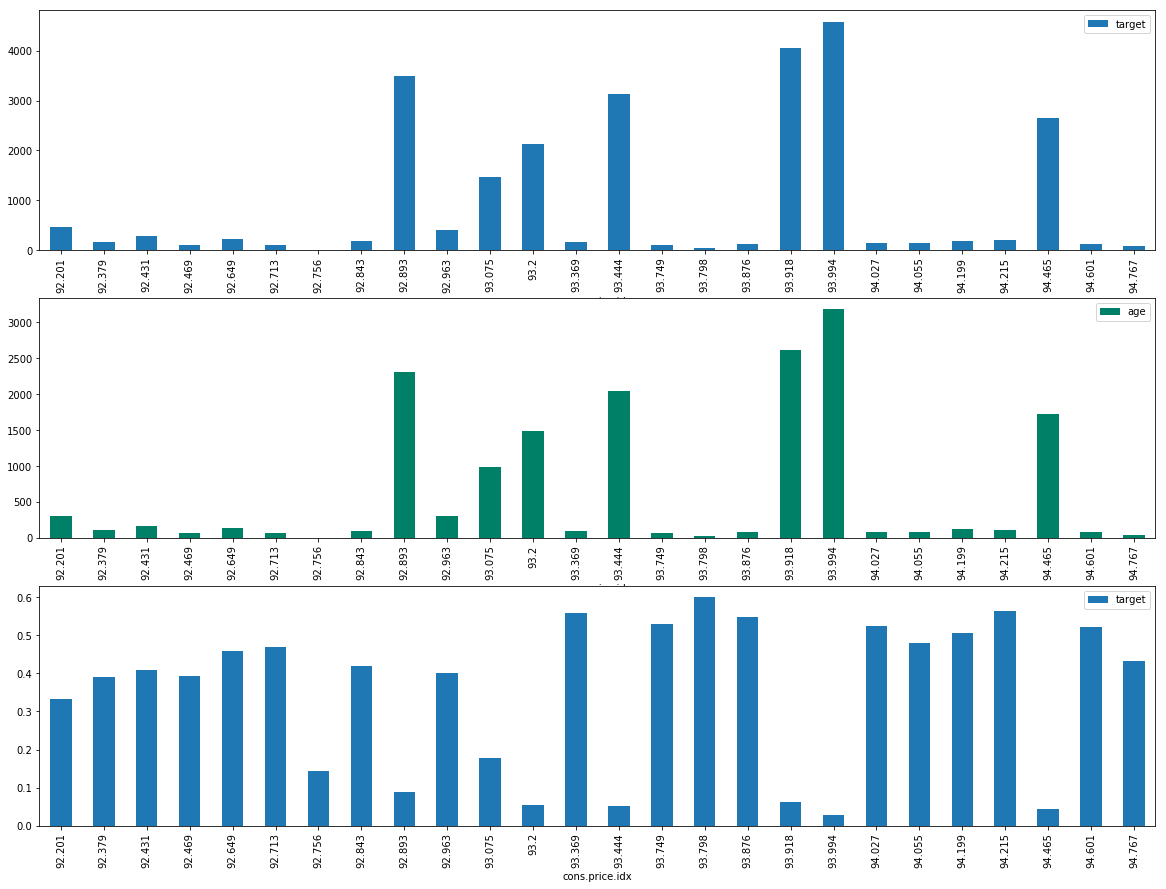

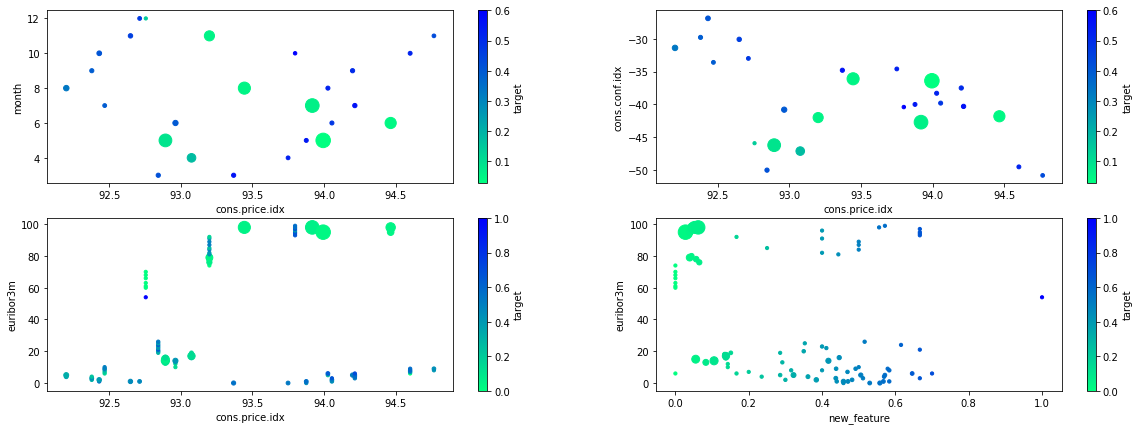

In [28]:
f = 'cons.price.idx'
def test_fin(df):
    df = df.copy().reset_index()
    
    months = {
        'apr' : 4,
        'aug' : 8,
        'dec' : 12,
        'jul' : 7,
        'jun' : 6,
        'mar' : 3,
        'may' : 5,
        'nov' : 11,
        'oct' : 10,
        'sep' : 9        
    }
    day_of_week = {
        'fri' : 5,
        'mon' : 1,
        'thu' : 4,
        'tue' : 2,
        'wed' : 3
    }
    job ={
        'blue-collar': 1,
        'services': 2,
        'entrepreneur': 3,
        'housemaid': 4,
        'unknown': 5,
        'self-employed': 6,
        'technician': 7,
        'management': 8,
        'admin.': 9,
        'unemployed': 10,
        'retired': 11,
        'student': 12
    }
    
    df.month = df.month.map(lambda x: months[x])
    df.day_of_week = df.day_of_week.map(lambda x: day_of_week[x])
    df.job = df.job.map(lambda x: job[x])
    
    fig, axes = pyplot.subplots(3,1, squeeze=False, figsize=(20,15))
    
    dfg = df[(df['csv']=='train')].groupby([f]).agg({'target':'count'}).reset_index()
    
    dfg.plot(x=f, kind='bar', ax = axes[0,0])
    #dfg.apply(lambda x: axes[0,0].annotate(x['target'], (x['month']-3.25, x['target']+200)), axis=1)
    
    dfgm = df.groupby([f]).agg({'target':'mean'}).reset_index()
    dfgm.plot(x=f, kind='bar', ax = axes[2,0])
    
#    dfgm['target'] = dfg['target']*(dfgm['target']**1.55) #достаточно хорошо выравнивает график
#    dfgm.plot(x='campaign', kind='bar', ax = axes[3,0])
    
    dfg = df[(df['csv']=='test') ].groupby([f]).agg({'age':'count'}).reset_index()
    
    dfg.plot(x=f, kind='bar', ax = axes[1,0], cmap=pyplot.cm.summer)
    #dfg.apply(lambda x: axes[1,0].annotate(x['age'], (x['campaign']-3.25, x['age']+200)), axis=1)

    min_e, max_e = df['euribor3m'].min(), df['euribor3m'].max()
    step = (max_e-min_e)/100
    df['euribor3m'] = df['euribor3m'].map(lambda x: (x-min_e)//step)
    
    dfn = df[(df['csv']=='train')].groupby(
        [f, 'cons.conf.idx', 'month', 'euribor3m']
    ).agg({'target':'mean'}).reset_index().rename(columns={'target':'new_feature'})
    
    dfn = pd.merge(left=df, right=dfn, on=list(dfn.columns)[:-1])
    

    
    fig, axes = pyplot.subplots(2,2, squeeze=False, figsize=(20,7))    
    show_scatter(df = df[(df['csv']=='train')], x =f, y ='month', hue='target', ax = axes[0,0], agg_func='mean')    
    show_scatter(df = df[(df['csv']=='train')], x =f, y ='cons.conf.idx', hue='target', ax = axes[0,1], agg_func='mean')
    show_scatter(df = df[(df['csv']=='train')], x =f, y ='euribor3m', hue='target', ax = axes[1,0], agg_func='mean')
    show_scatter(df = dfn, x ='new_feature', y ='euribor3m', hue='target', ax = axes[1,1], agg_func='mean')
    
    return {'min_e': min_e, 'max_e': max_e, 'step': step}, df[(df['csv']=='train')].groupby(
        [f, 'cons.conf.idx', 'month', 'euribor3m']
    ).agg({'target':'mean', 'age':'count'}).reset_index().sort_values(by='target').rename(
        columns={'target':'x4financial', 'age':'count'}
    )

euribor3m_vars, x4financial = test_fin(train_test)
x4financial = x4financial.drop(columns='count')

##### ['cons.price.idx', 'cons.conf.idx', 'month', 'euribor3m']
указанные выше переменные хорошо коррелируют между собой, и плохо с другими.
создаим новую фичу на их основе __x4financial__

# Немного локальных утилит

In [68]:
#помогаем вывести  полезную статистику по фиче
def print_column_info(df, cname):
    print("{}: {}".format(
            cname,
            description.loc[cname, 'description']
        ))
    if len(df[cname].unique())>20:
        print('первые 50 уникальных значений: {}'.format( list(df[cname].unique())[:20] ) )
    else:
        print(df.groupby(cname).agg({cname:'count', 'target':'mean'}).sort_values(by="target"))
    print('\n\n')

In [69]:
#почти тоже самое, когда юзал, но более не пригодилось
def print_grouped_column_info(df, cname, group_by):
    
    df=df.copy()
    df['row_counter'] = 1
    
    print("{}: {}".format(
            cname,
            description.loc[cname, 'description']
        ))
    
    if len(df[cname].unique())>20:
        print('первые 50 уникальных значений: {}'.format( list(df[cname].unique())[:20] ) )
    else:
        print(pd.pivot_table(df, values=['target','row_counter'], index=[cname], columns=[group_by], aggfunc={'row_counter':'count', 'target':'mean'}).sort_values([('target', 'train')]))
    print('\n\n')    

## Функция поиская всех возможных уникальных комбинаций элементов 

In [70]:
def get_features_combinations(columns, n, primary_columns = None):    
        
    comb = []
    
    cols = enumerate(columns[:(-n+1)]) if (primary_columns is None) else enumerate([x for x in primary_columns if not (x in columns)])
    
    if n == 2:
        for i, item in cols:
            for subitem in columns[i+1:]:
                comb.append([item, subitem])
    
    else:
        for i, item in cols:
            for subitems in get_features_combinations(columns[i+1:], n-1):
                comb.append([item] + subitems)
                
    return comb

## Посмотрим на строковые фичи 

In [32]:
for cname in train.columns:
    if train.dtypes[cname] == object:    
        print_grouped_column_info(train_test, cname, 'csv')

job: тип работы (admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown)
              row_counter          target
csv                  test train     train
job                                      
blue-collar          3633  5621  0.071873
services             1578  2391  0.079046
entrepreneur          603   853  0.085580
housemaid             408   652  0.098160
unknown               133   197  0.101523
self-employed         571   850  0.102353
technician           2756  3987  0.107600
management           1166  1758  0.115472
admin.               4168  6254  0.131916
unemployed            420   594  0.144781
retired               719  1001  0.239760
student               321   554  0.301444



marital: семейное положение (divorced (разведенный и овдовевший),married,single,unknown)
         row_counter           target
csv             test  train     train
marital                              
married        10057  14

### Оцифровка текстовых категорий

In [33]:
category_mapper = {
    'job':{
        'blue-collar': 1,
        'services': 2,
        'entrepreneur': 3,
        'housemaid': 4,
        'unknown': 5,
        'self-employed': 6,
        'technician': 7,
        'management': 8,
        'admin.': 9,
        'unemployed': 10,
        'retired': 11,
        'student': 12
    },
    'marital':{
        'divorced' : 3,
        'married' : 2,
        'single' : 1,
        'unknown' : 0
    },
    'education':{
        'unknown' : 0,
        'illiterate' : 1,
        'basic.4y' : 2,
        'basic.6y' : 3,
        'basic.9y' : 4,
        'high.school' : 5,
        'professional.course' : 6,
        'university.degree' : 7
    },
    'default': {
        'no' : 0,
        'unknown' : 1,
        'yes' : 1
    },
    'housing' : {
        'no' : 0,
        'unknown' : 1,
        'yes' : 2
    },
    'loan' : {
        'no' : 0,
        'unknown' : 1,
        'yes' : 2
    },
    'contact' : {
        'cellular' : 1,
        'telephone' : 0
    },
    'month' : {
        'apr' : 4,
        'aug' : 8,
        'dec' : 12,
        'jul' : 7,
        'jun' : 6,
        'mar' : 3,
        'may' : 5,
        'nov' : 11,
        'oct' : 10,
        'sep' : 9        
    },
    'day_of_week' : {
        'fri' : 5,
        'mon' : 1,
        'thu' : 4,
        'tue' : 2,
        'wed' : 3
    },
    'poutcome' : {
        'failure' : 1,
        'nonexistent' : 0,
        'success' : 2
    }
}
category_ohe = [
    
]

### Пишем функцию преобразования данных

In [34]:
def map_categories(df, mapper, one_hot):
    df = df.copy()
    
    if False:
        df['duration_&_previous'] = -3.6064671271553124 + df['duration']*0.0037342820277683555 + df['previous']*1.0693138449645634
        marketing_activity_sets = {
            'apr' : 1,
            'aug' : 2,
            'dec' : 0,
            'jul' : 2,
            'jun' : 2,
            'mar' : 0,
            'may' : 3,
            'nov' : 2,
            'oct' : 0,
            'sep' : 0
        }
        df['marketing_activity'] = df['month'].map(lambda x: marketing_activity_sets[x])
        target_audience_sets = {
            'apr' : [29, 60],
            'aug' : [29, 60],
            'dec' : [0, 0],
            'jul' : [24, 60],
            'jun' : [24, 60],
            'mar' : [0, 0],
            'may' : [24, 60],
            'nov' : [0, 0],
            'oct' : [29, 60],
            'sep' : [0, 0]
        }

        df['target_audience'] =  df.apply(
            (lambda x: 1 if (target_audience_sets[x['month']][0] <= x['age'] <= target_audience_sets[x['month']][1]) else 0),
            axis='columns'
        )

        df['campaign'] = df['campaign'].map(prepare_campaign)
        df['pdays'] = df['pdays'].map(lambda x: 1 if x < 999 else 0)

        df['euribor3m'] = df['euribor3m'].map(lambda x: (x-euribor3m_vars['min_e'])//euribor3m_vars['step'])
        
        
        df['duration'] = df['duration'].map(lambda x: x // 60 * 60 if (x // 60 * 60) < 360 else 360)
        df['age'] = df['age'].map(lambda x: x // 10 * 10 if (x // 10 * 10) < 60 else 60)
        
        category_mapper = [x for x in mapper if ~(x in one_hot)]

        for key, value in mapper.items():
            if key in list(df.columns):
                df.loc[:,key] = df.loc[:,key].map(lambda x: value[x])

        df = pd.merge(left=df.reset_index(), right=emp_map, on=list(emp_map.columns)[:-1]).set_index('_id')

        df = pd.merge(left=df.reset_index(), right=x4financial, on=list(x4financial.columns)[:-1]).set_index('_id')

        df = df.drop(columns=(list(set(
#            ['duration', 'previous', 'age', 'day_of_week'] +
            list(emp_map.columns)[:-1] +
            list(x4financial.columns)[:-1]
        ))))
    
    else:
        category_mapper = [x for x in mapper if ~(x in one_hot)]

        for key, value in mapper.items():
            if key in list(df.columns):
                df.loc[:,key] = df.loc[:,key].map(lambda x: value[x])

    
    if len(one_hot)>0:
        df = pd.get_dummies(df, columns=one_hot)
        for key in one_hot:
            df.drop(columns=[x for x in list(df.columns) if key in x.split("_")])
    
    return df

In [71]:
#Используем RFE для определения самых важных фич
def get_best_features(X_train, y_train, n_best_features):
    
    rfe = RFE(DecisionTreeClassifier(max_depth=10, random_state = 42), n_best_features)
    fit_support = rfe.fit(X_train, y_train).support_
    
    return [x for idx, x in enumerate(X_train.columns) if fit_support[idx]]

#а это еще один преобразователь, он принимает трейн и тест. 
#Он на основе комбинаций фич трейна, предсказывает исходы комбинаций теста
def test_predict_probe_to_pairs(X_train, y_train, n_neighbors, feature_pairs):
    
    X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
    
    results = []
    
    estimators = [
        ['KNN', KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)],
        ['DTC', DecisionTreeClassifier(max_depth=5, random_state=42)],
        ['LR', LogisticRegression(random_state=42)],
    ]
    
    for features in feature_pairs:
        
        est_results =[]
        
        for name, estimator in estimators:
            
            estimator.fit(X_tr[features], y_tr)
            predict_proba = estimator.predict_proba(X_ts[features])
            
            r_a_s = roc_auc_score(y_ts, predict_proba[:,1])
            l_l = log_loss(y_ts, predict_proba[:,1])
            
            descr = '{} Признаки: {}; log_loss: {:.4f}; roc_auc: {:.1%}'.format(
                name,
                ', '.join(features), 
                l_l,
                r_a_s
            )
        
            est_results.append([name, features, r_a_s, descr])
        
        est_results.sort(key=(lambda x: x[1]), reverse=True)
        
        results.append(est_results[0])
    
    if len(results)>0:
        results.sort(key=(lambda item: item[2]), reverse=True)
        return results

In [72]:
#немного утилит для быстрого теста
def get_estimator(name, n_neighbors):
    if name == 'KNN':
        return KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
    
    if name == 'DTC':
        return DecisionTreeClassifier(random_state=42)
    
    if name == 'LR':
        return LogisticRegression(random_state=42)

class TestDFException(Exception):
    pass
    
def add_predict_probe(X_train, y_train, X_test, feature_pairs, n_neighbors):
    
    if 'target' in X_test.columns: raise TestDFException("X_test contains 'target' as a feature")
    
    for e_name, features in [x[:2] for x in feature_pairs]:

        estimator = get_estimator(e_name, n_neighbors)
        estimator.fit(X_train[features], y_train)
        
        X_test.loc[:, '_&_'.join(features)] = estimator.predict_proba(X_test[features])[:,1]
    
    return X_test

In [73]:
#еще одна функция преобразования данных
def prepare_data_test(X_train, y_train, X_test):
    
    if 'target' in X_test.columns: raise TestDFException("X_test contains 'target' as a feature")
        
#    X_train = map_categories(X_train, category_mapper, category_ohe)
    
    best_features = get_best_features(X_train, y_train, 15)
    
    bad_features = [x for x in list(X_train.columns) if not (x in best_features)]
    
    if False:
        print('test_predict_probe_to_pairs')
        feature_combinations = test_predict_probe_to_pairs(
            X_train, 
            y_train,
            20,
            get_features_combinations(bad_features, 2, best_features) + 
            get_features_combinations(bad_features, 3, best_features)
        )[:64]

        print('add_predict_probe X_train')
        X_train = add_predict_probe(
            X_train, 
            y_train,
            X_train, 
            feature_combinations, 
            64
        )

        rfe = RFE(DecisionTreeClassifier(max_depth=10, random_state = 42), 20)
        fit = rfe.fit(X_train, y_train)
        X_best_features = [x for idx, x in enumerate(X_train.columns) if fit.support_[idx]]

        print('prepare X_test sarted')
    
#    X_test = map_categories(X_test, category_mapper, category_ohe)
    
        print('add_predict_probe X_test')
        X_test = add_predict_probe(
            X_train,
            y_train,
            X_test,
            feature_combinations,
            64
        )
    
        X_train = X_train[X_best_features]
        X_test = X_test[X_best_features]
    
    X_train = X_train[best_features]
    X_test = X_test[best_features]
    
    print('prepare_data_test complete')
    return X_train, X_test

In [74]:
#утилита для тестирования черных ящиков
def test_model(X_train, y_train, X_test, y_test, estimator, descr = 'test_model'):
    
    estimator.fit(X_train, y_train)
    predict_proba = estimator.predict_proba(X_test)
    predict = estimator.predict(X_test)
    
    print('{}: roc_auc = {:.2%}, precision= {:.2%}, recall={:.2%}, log_loss={:.2%}'.format(
        descr,
        roc_auc_score(y_test, predict_proba[:,1]),
        precision_score(y_test, predict),
        recall_score(y_test, predict),
        log_loss(y_test, predict_proba)
    ))

In [75]:
#утилита для тестирования черных ящиков
def test_predict_by_feauters(X_train, y_train, X_test, y_test, feauters = None):
        
    if not (feauters is None): X_train = X_train[feauters]
    
    estimators = [
        [DecisionTreeClassifier(max_depth=5, random_state = 42), 'DTC 5'],
        [DecisionTreeClassifier(max_depth=7, random_state = 42), 'DTC 7'],
        [DecisionTreeClassifier(max_depth=10, random_state = 42), 'DTC 10'],
        [DecisionTreeClassifier(max_depth=15, random_state = 42), 'DTC 15'],
        [RandomForestClassifier(max_depth=5, n_estimators=100, random_state = 42, n_jobs=-1), 'RFC 5'],
        [RandomForestClassifier(max_depth=7, n_estimators=100, random_state = 42, n_jobs=-1), 'RFC 7'],
        [RandomForestClassifier(max_depth=10, n_estimators=100, random_state = 42, n_jobs=-1), 'RFC 10'],
        [RandomForestClassifier(max_depth=15, n_estimators=100, random_state = 42, n_jobs=-1), 'RFC 15'],
        [LogisticRegression(random_state = 42), 'LR']
    ]
    
    for estimator, descr in estimators:
        test_model(X_train, y_train, X_test, y_test, estimator, descr)

## Проводим тест на сплите трейна

In [41]:
%%time

mapped_train = map_categories(train, category_mapper, ['month','job','education'])
X_tr, X_ts, y_tr, y_ts = train_test_split(mapped_train.drop(columns=['target']), list(mapped_train['target']), test_size=0.3, random_state=42)

Wall time: 134 ms


In [42]:
%%time
X_tr_prepared, X_ts_prepared = prepare_data_test(X_tr, y_tr, X_ts)

prepare_data_test complete
Wall time: 2.05 s


In [43]:
X_tr_prepared.columns

Index(['age', 'marital', 'housing', 'contact', 'day_of_week', 'duration',
       'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'month_10', 'education_7'],
      dtype='object')

In [44]:
test_predict_by_feauters(
    X_tr_prepared, y_tr, 
    X_ts_prepared, y_ts
)

DTC 5: roc_auc = 92.23%, precision= 64.12%, recall=52.79%, log_loss=20.14%
DTC 7: roc_auc = 90.69%, precision= 64.28%, recall=52.08%, log_loss=36.91%
DTC 10: roc_auc = 84.33%, precision= 62.25%, recall=55.75%, log_loss=98.52%
DTC 15: roc_auc = 75.42%, precision= 54.23%, recall=55.52%, log_loss=295.23%
RFC 5: roc_auc = 93.05%, precision= 79.18%, recall=23.01%, log_loss=21.34%
RFC 7: roc_auc = 94.03%, precision= 75.72%, recall=31.08%, log_loss=19.56%
RFC 10: roc_auc = 94.35%, precision= 68.76%, recall=46.74%, log_loss=18.41%
RFC 15: roc_auc = 94.14%, precision= 65.85%, recall=51.01%, log_loss=18.31%
LR: roc_auc = 92.37%, precision= 66.12%, recall=38.20%, log_loss=21.88%


## Предсказываем для kaggle

In [56]:
%%time

mapped_train = map_categories(train,category_mapper,['month', 'job', 'education'])
X, y = mapped_train.drop(columns='target'), list(mapped_train['target'])
X, X_test_prepared = prepare_data_test(X, y, 
                                       map_categories(X_test, category_mapper,['month', 'job', 'education'])
                                      )

estimator = RandomForestClassifier(max_depth=10, n_estimators=100, random_state = 42, n_jobs=-1)
#estimator = DecisionTreeClassifier(max_depth=10, criterion='entropy', random_state = 42)
estimator.fit(X, y)
predict_proba = estimator.predict_proba(
    X_test_prepared
)

prepare_data_test complete
Wall time: 3.7 s


In [57]:
y_test = pd.DataFrame(predict_proba[:,1], X_test_prepared.index, columns=['target'])

In [58]:
y_test.head()

,target
_id,
66810d8e6bf2b41c880a7bc6c8a1e295,0.087711
ccac3879652b08cb8b44c1920fd93afa,0.007099
fcccab4d7a76f70647f015f2c84c2af8,0.017863
ed8399278c30678dab739045fa12b440,0.012351
1d4d62ac5cabcb48bac7112813f290cb,0.011317


In [59]:
import datetime

In [60]:
y_test.to_csv('submission' + datetime.datetime.now().strftime( '-%Y-%m-%d_%H-%M' ) + '.csv')

# Yeap!